In [1]:
import numpy as np
import pandas as pd
import random
import nl4py
from skimage.measure import label, regionprops, regionprops_table

from itertools import product
import multiprocessing
import ast

# EA Framework

In [2]:
def get_full_param_list(n):
    parNames = n.getParamNames()
    parRanges = n.getParamRanges()
    parRanges = [np.array(k).astype(int) for k in parRanges]
    c = 0
    
    full_parameter_list = dict.fromkeys(parNames)
    
    for par in parNames:
        par_range = []
        for i in range(int(parRanges[c][2] / parRanges[c][1]) + 1):
            par_range.append(parRanges[c][0] + i*parRanges[c][1])
        full_parameter_list[par] = par_range
        c = c + 1
    return full_parameter_list

In [3]:
class EvolutionaryAlgorithm:
    def __init__(
        self,
        num_cores=None,
        model_path=None,
        population=None,
        generations=None,
        reproduction_rate=None,
        mutation_rate=None,
        iterations=None,
        max_steps=None
    ):
        self.num_cores = num_cores
        self.model_path = model_path
        self.population = population
        self.generations = generations
        self.reproduction_rate = reproduction_rate
        self.mutation_rate = mutation_rate
        self.iterations = iterations
        self.max_steps = max_steps
        
#         nl4py.startServer("/Applications/NetLogo 6.0.4/")
        n = nl4py.newNetLogoHeadlessWorkspace()
        n.openModel(self.model_path)
        full_parameter_list = get_full_param_list(n)
        print(full_parameter_list)
        self.parameter_list = full_parameter_list
        
        self.param_names = list(self.parameter_list.keys())
        self.generate_workspaces()
            
    def generate_workspaces(self):
        self.workspaces = []
        nl4py.deleteAllHeadlessWorkspaces()
        for i in range(num_cores):
            n = nl4py.newNetLogoHeadlessWorkspace()
            n.openModel(self.model_path)
            self.workspaces.append([n,0])
            
    def EA(self):
        # Run initial parameter population, report error
        self.outputs_all = []
        self.parameter_population = self.generate_random_params(self.population)
        run_matrix = self.generate_run_matrix(self.parameter_population)
        self.outputs = self.schedule_run_all_param_combinations(self.parameter_population,run_matrix)
        self.outputs_all.append(self.outputs)

        # Summarize initial outputs
        print('---Generation 0---')
        [generation_average, generation_minimum,generation_minimum_parm] = self.summarize_outputs()
        print('generation_average: {}'.format(generation_average))
        print('generation_minimum: {}'.format(generation_minimum))
        print(generation_minimum_parm)
        
        for i in range(self.generations):
            print(len(self.parameter_population))
            print(len(self.outputs))
            offsprings = self.generate_offspring()
            
            run_matrix = self.generate_run_matrix(offsprings)
            offspring_outputs = self.schedule_run_all_param_combinations(offsprings,run_matrix)
            
            print("I ran the model.")
            for k in offspring_outputs:
                self.outputs[k] = offspring_outputs[k]
            self.kill_parameters()
            
            self.outputs_all.append(self.outputs)
            print('---Generation {}---'.format(i+1))
            [generation_average, generation_minimum,generation_minimum_parm] = self.summarize_outputs()
            print('generation_average: {}'.format(generation_average))
            print('generation_minimum: {}'.format(generation_minimum))
            print(generation_minimum_parm)
            
        for workspace in self.workspaces:
            nl4py.deleteHeadlessWorkspace(workspace[0])
        
#         nl4py.stopServer()
#         print(self.outputs_all)
        return self.outputs_all
        
    def schedule_run_all_param_combinations(self,parameter_population,full_run_matrix):
#         parameter_population = self.generate_random_params()
#         full_run_matrix = self.generate_run_matrix(parameter_population)
        
        # determine how many times parallelization of cores must be repeated to complete runs
        total_runs = len(full_run_matrix)
        runsDone = 0
        runsStarted = 0
        outputs_all = {str(i):[] for i in parameter_population}
        
        for workspace in self.workspaces:
            self.create_and_run_model(full_run_matrix[runsStarted],workspace[0])
            workspace[1] = full_run_matrix[runsStarted]
            runsStarted = runsStarted + 1
          
        while runsDone < total_runs:
            for workspace in self.workspaces:
                newResults = workspace[0].getScheduledReporterResults()
                if len(newResults) > 0:
                    workspace[0].command("stop")
#                     print('Run {} finished.'.format(workspace[1])) 
                    ###Process simulation results###
                    output = newResults[99]
                    output_error = self.calculate_output_error(output)
                    outputs_all[str(workspace[1])].append(output_error)
                    ###Done processing simulation results###
                    runsDone = runsDone + 1
                    if runsStarted < total_runs:
                        self.create_and_run_model(full_run_matrix[runsStarted],workspace[0])
                        workspace[1] = full_run_matrix[runsStarted]
                        runsStarted = runsStarted + 1
        for workspace in self.workspaces:
            workspace[0].command("stop")

        return outputs_all  
            
    def generate_random_params(self,pop):
        random_param_population = []
        for i in range(pop):
            param_comb_i = dict.fromkeys(self.parameter_list.keys())
            for par in list(self.parameter_list.keys()):
                param_comb_i[par] = np.random.choice(self.parameter_list[par])
            random_param_population.append(param_comb_i)
        return random_param_population

    def generate_run_matrix(self, random_parameter_population):
        full_run_matrix = [i for i in random_parameter_population for k in range(self.iterations)]
        return full_run_matrix
    
    def create_and_run_model(self, param_comb, n):
        # Setup agents
        n.command("setup")
        check = n.report("count turtles")
        while check == 0.0 or check == None:
            n.command("setup")
            check = n.report("count turtles")
#         print('Number of Turtles: {}'.format(n.report("count turtles")))

        # Set parameter values
        parNames = list(param_comb.keys())
        for par in parNames:
            cmd = 'set {0} {1}'.format(par,param_comb[par])
            n.command(cmd)
            check = n.report(par)
            while(check != param_comb[par] or check == None):
                n.command(cmd)
                check = n.report(par)
#             print('{}: {}'.format(par,check))
        n.command("reset-ticks")
    
        # Run the model
        n.command("adjust-exp")
        check = n.report("exp-expression-const")
        while check == None:
            check = n.report("exp-expression-const")
#         print('Adjust-Exp: {}'.format(n.report("exp-expression-const")))

        reporters = ["count turtles", 
                     "count turtles with [color = green]",
                    "count turtles with [color = red]",
                    "count turtles with [color = blue]",
                    "count turtles with [color = gray]",
                    "[xcor] of turtles with [color = green]",
                    "[ycor] of turtles with [color = green]",
                    "[xcor] of turtles with [color = red]",
                    "[ycor] of turtles with [color = red]"]

        n.scheduleReportersAndRun(reporters,0,1,self.max_steps,"go")
#         print('Run {} started.'.format(param_comb)) 

    def calculate_output_error(self,results):
        exp_metrics={
                    "green_fract": 0.48224608,
                    "red_fract": 0.370580433,
                    "blue_fract": 0.274062823,
                    "num_green_regions": 1,
                    "avg_green_region_area": 0.58,
                    "num_red_regions": 2.1,
                    "avg_red_region_area": 0.24
                    }
        img_green = np.zeros((17,17))
        img_red = np.zeros((17,17))

        green_x = results[5]
        green_y = results[6]
        green_x = np.fromstring(green_x[1:-1],sep=',')
        green_y = np.fromstring(green_y[1:-1],sep=',')

        for (x,y) in zip(green_x,green_y):
            img_green[int(x)+8][int(y)+8] = 1

        red_x = results[7]
        red_y = results[8]
        red_x = np.fromstring(red_x[1:-1],sep=',')
        red_y = np.fromstring(red_y[1:-1],sep=',')

        for (x,y) in zip(red_x,red_y):
            img_red[int(x)+8][int(y)+8] = 1

        label_img_green = label(img_green,connectivity=1)
        green_props_test = regionprops(label_img_green)
        if len(green_props_test) > 0:
            green_props = regionprops_table(label_img_green, properties=('centroid','area'))
            green_props=pd.DataFrame(green_props)
            num_green_regions = sum(green_props.area > 2)
            if num_green_regions > 0:
                avg_green_region_area = sum(green_props.area[green_props.area > 2]) / num_green_regions
            else:
                avg_green_region_area = 0
        else:
            num_green_regions = 0
            avg_green_region_area = 0

        label_img_red = label(img_red,connectivity=1)
        red_props_test = regionprops(label_img_red)
        if len(red_props_test) > 0:
            red_props = regionprops_table(label_img_red, properties=('centroid','area'))
            red_props = pd.DataFrame(red_props)
            num_red_regions = sum(red_props.area > 2)
            if num_red_regions > 0:
                avg_red_region_area = sum(red_props.area[red_props.area > 2]) / num_red_regions
            else:
                avg_red_region_area = 0
        else:
            num_red_regions = 0
            avg_red_region_area = 0

        output_metrics={
                "green_fract": float(results[1]) / 56,
                "red_fract": float(results[2]) / 56,
                "blue_fract": float(results[3]) / 56,
                "num_green_regions": num_green_regions,
                "avg_green_region_area": avg_green_region_area / 56,
                "num_red_regions": num_red_regions,
                "avg_red_region_area": avg_red_region_area / 56
                }
#         print(output_metrics)

        # Calculate errordict.fromkeys(parNames)
        output_metrics = list(output_metrics.values())
        exp_metrics = list(exp_metrics.values())
        individual_errors = np.abs(np.array(output_metrics) - np.array(exp_metrics))
        error = (np.exp(individual_errors.sum()) - 1) ** 2
#         print(error)
        return [individual_errors, error]

    def summarize_outputs(self):
        self.param_averages = {k: np.average([i[1] for i in self.outputs[k]]) for k in self.outputs}
        generation_average = np.mean([self.param_averages[k] for k in self.param_averages])
        generation_minimum = np.min([self.param_averages[k] for k in self.param_averages])
        generation_minimum_parm = min(self.param_averages,key=self.param_averages.get)
        return generation_average, generation_minimum,generation_minimum_parm
    
    def generate_offspring(self):
        # generate offsprings
        self.previous_parameter_population = self.parameter_population
        self.parameter_population = []
        
        self.previous_outputs = self.outputs
        self.outputs = {}
        
        for i in range(self.population - int(self.reproduction_rate*self.population)):
            min_key = min(self.param_averages,key=self.param_averages.get)
            self.parameter_population.append(ast.literal_eval(min_key))
            self.outputs[min_key] = self.previous_outputs[min_key]
            self.param_averages.pop(min_key)
            
            
        offsprings = []
        for i in range(int(self.reproduction_rate*self.population) - int(self.mutation_rate*self.population)):
            # select parents
            choices = np.random.choice(list(self.param_averages.keys()), 5)
            choices = {str(k):self.param_averages[str(k)] for k in choices}

            parent_1_key = min(choices,key=choices.get)
            parent_1 = ast.literal_eval(parent_1_key)
            choices.pop(parent_1_key)
            
            parent_2_key = min(choices,key=choices.get)
            parent_2 = ast.literal_eval(parent_2_key)

            # random cross over
            offspring = {k: np.random.choice([parent_1[k],parent_2[k]]) for k in self.param_names}
            while offspring in self.parameter_population:
                # generate parents
                choices = np.random.choice(list(self.param_averages.keys()), 5)
                choices = {str(k):self.param_averages[str(k)] for k in choices}
                parent_1_key = min(choices,key=choices.get)
                parent_1 = ast.literal_eval(parent_1_key)
                choices.pop(parent_1_key)
                parent_2_key = min(choices,key=choices.get)
                parent_2 = ast.literal_eval(parent_2_key)
                # random cross over
                offspring = {k: np.random.choice([parent_1[k],parent_2[k]]) for k in self.param_names}
            offsprings.append(offspring)
            self.parameter_population.append(offspring)
            
        # create mutants
        for i in range(int(self.mutation_rate*self.population)):
            offspring_mutant = self.generate_random_params(1)
            while offspring_mutant[0] in self.parameter_population:
                offspring_mutant = self.generate_random_params(1)
            offsprings.append(offspring_mutant[0])
            self.parameter_population.append(offspring_mutant[0])
            
        print("im here")
        return offsprings
            
    def kill_parameters(self):
        self.param_averages = {k: np.average([i[1] for i in self.outputs[k]]) for k in self.outputs}
        for i in range(len(self.parameter_population) - self.population):
            max_key = max(EA.param_averages,key=EA.param_averages.get)
            self.parameter_population.remove(ast.literal_eval(max_key))
            self.outputs.pop(max_key)
            self.param_averages.pop(max_key)

### Ideal Error Measurement

In [4]:
output_metrics={
                "green_fract": 0.4403066,
                "red_fract": 0.3755106,
                "blue_fract": 0.003061229,
                "num_green_regions": 1.285714,
                "avg_green_region_area": 0.359481,
                "num_red_regions": 2.928571,
                "avg_red_region_area": 0.1027045
                }

In [5]:
exp_metrics={
                "green_fract": 0.48224608,
                    "red_fract": 0.370580433,
                    "blue_fract": 0.274062823,
                    "num_green_regions": 1,
                    "avg_green_region_area": 0.58,
                    "num_red_regions": 2.1,
                    "avg_red_region_area": 0.24
            }

In [6]:
output_metrics = list(output_metrics.values())
exp_metrics = list(exp_metrics.values())
individual_errors = np.abs(np.array(output_metrics) - np.array(exp_metrics))
error = np.exp(individual_errors.sum())**2

In [7]:
error

35.87144166062016

# Running the Evolutionary Algorithm

### Tuning Exp-Expression-Const and Homotypic-Prob for all Output Metrics

In [8]:
nl4py.startServer("/Applications/NetLogo 6.0.4/")

In [9]:
num_cores = 4
model_path = "Users/niki/Dropbox/Nikita/College/Projects/Lazzara Lab/ABM_Wendell&Lim/Circuit_ABCD_Asymm_01/Callibrate-ABM-HPC/Circuit_ABCD_Asymm_3.1_ParameterTuning.nlogo"
population = 20
generations= 10
reproduction_rate = 0.8
mutation_rate = 0.25
iterations = 10
max_steps = 100

EA = EvolutionaryAlgorithm(num_cores,model_path,population,generations,reproduction_rate,mutation_rate,
                           iterations,max_steps)

{'exp-expression-const': [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], 'homotypic-prob': [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]}


In [10]:
EA_results_exp_error = EA.EA()

---Generation 0---
generation_average: 5530.379520051964
generation_minimum: 50.59200181468202
{'exp-expression-const': 10, 'homotypic-prob': 70}
20
20
im here
I ran the model.
---Generation 1---
generation_average: 2896.6469595551794
generation_minimum: 50.59200181468202
{'exp-expression-const': 10, 'homotypic-prob': 70}
20
20
im here
I ran the model.
---Generation 2---
generation_average: 1811.582329662293
generation_minimum: 50.59200181468202
{'exp-expression-const': 10, 'homotypic-prob': 70}
20
20
im here
I ran the model.
---Generation 3---
generation_average: 2271.4203957861546
generation_minimum: 50.59200181468202
{'exp-expression-const': 10, 'homotypic-prob': 70}
20
20
im here
I ran the model.
---Generation 4---
generation_average: 755.477582391477
generation_minimum: 50.59200181468202
{'exp-expression-const': 10, 'homotypic-prob': 70}
20
20
im here
I ran the model.
---Generation 5---
generation_average: 2977.065950707988
generation_minimum: 50.59200181468202
{'exp-expression-co

In [11]:
num_cores = 4
model_path = "Users/niki/Dropbox/Nikita/College/Projects/Lazzara Lab/ABM_Wendell&Lim/Circuit_ABCD_Asymm_01/Callibrate-ABM-HPC/Circuit_ABCD_Asymm_3.1_ParameterTuning.nlogo"
population = 20
generations= 100
reproduction_rate = 0.8
mutation_rate = 0.25
iterations = 10
max_steps = 100

EA_30_gen = EvolutionaryAlgorithm(num_cores,model_path,population,generations,reproduction_rate,mutation_rate,
                           iterations,max_steps)

{'exp-expression-const': [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], 'homotypic-prob': [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]}


In [12]:
EA_results_30_gen_exp_error = EA_30_gen.EA()

---Generation 0---
generation_average: 4279.282172296248
generation_minimum: 190.35857350436854
{'exp-expression-const': 50, 'homotypic-prob': 30}
20
20
im here
I ran the model.
---Generation 1---
generation_average: 1303.9619078665712
generation_minimum: 190.35857350436854
{'exp-expression-const': 50, 'homotypic-prob': 30}
20
20
im here
I ran the model.
---Generation 2---
generation_average: 977.3059416759392
generation_minimum: 103.82005861300154
{'exp-expression-const': 30, 'homotypic-prob': 70}
20
20
im here
I ran the model.
---Generation 3---
generation_average: 1663.940973110557
generation_minimum: 59.45183094012581
{'exp-expression-const': 35, 'homotypic-prob': 80}
20
20
im here
I ran the model.
---Generation 4---
generation_average: 1174.6508727183295
generation_minimum: 46.093824368886494
{'exp-expression-const': 15, 'homotypic-prob': 55}
20
20
im here
I ran the model.
---Generation 5---
generation_average: 4549.2359077086385
generation_minimum: 46.093824368886494
{'exp-expres

In [17]:
EA_results_30_gen_param_averages =[{key: np.average([i[1] for i in j[key]]) for key in j} for j in EA_results_30_gen_exp_error]

In [18]:
EA_results_30_gen_mean_error=[np.mean([j[k] for k in j]) for j in EA_results_30_gen_param_averages]

In [19]:
EA_results_30_gen_min_error=[np.min([j[k] for k in j]) for j in EA_results_30_gen_param_averages]

Text(0, 0.5, 'Exponentially-Scaled Error')

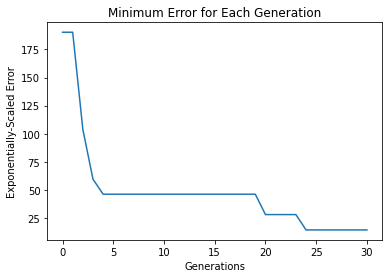

In [20]:
import matplotlib.pyplot as plt
plt.plot(range(31),EA_results_30_gen_min_error)
plt.title("Minimum Error for Each Generation")
plt.xlabel("Generations")
plt.ylabel("Exponentially-Scaled Error")

# Read in Files from Rivanna

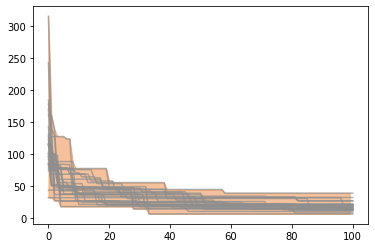

In [7]:
import matplotlib.pyplot as plt
import os
rootdir = 'Users/niki/Dropbox/Nikita/College/Projects/Lazzara Lab/ABM_Wendell&Lim/Circuit_ABCD_Asymm_01/Callibrate-ABM-HPC/EA_ExponentialError_HomotypicProb-ExpExpressionConst/'
first_min_errors = []
last_min_errors = []
gen_min_errors = [500]*100
gen_max_errors = [0]*100
first_params = []
last_params = []
for file in os.listdir(rootdir):
    if file[-1] == 't':
#         print(file)
        results_path = os.path.join(rootdir, file)
        results = open(results_path)
        results = results.read()
        results = results[results.find('[{"'):-1]
#         print(results)
        results = results.replace('\n','')
        results = results.replace('array(','')
        results = results.replace(')','')
        results = results.replace(' ','')
        results_pop_20_gen_100 = list(eval(results))
        results_pop_20_gen_100_param_averages=[{key: np.average([i[1] for i in j[key]]) for key in j} for j in results_pop_20_gen_100]
        results_pop_20_gen_100_mean_error=[np.mean([j[k] for k in j]) for j in results_pop_20_gen_100_param_averages]
        results_pop_20_gen_100_min_error=[np.min([j[k] for k in j]) for j in results_pop_20_gen_100_param_averages]
        
        for i in range(100):
            if results_pop_20_gen_100_min_error[i] < gen_min_errors[i]:
                gen_min_errors[i] = results_pop_20_gen_100_min_error[i]
            if results_pop_20_gen_100_min_error[i] > gen_max_errors[i]:
                gen_max_errors[i] = results_pop_20_gen_100_min_error[i]
        first_min_errors.append(results_pop_20_gen_100_min_error[0])
        last_min_errors.append(results_pop_20_gen_100_min_error[100])
        first_params.append(min(results_pop_20_gen_100_param_averages[0],key=results_pop_20_gen_100_param_averages[0].get))
        last_params.append(min(results_pop_20_gen_100_param_averages[100],key=results_pop_20_gen_100_param_averages[100].get))
        
        plt.plot(range(101),results_pop_20_gen_100_min_error,color="#8E8E8E",alpha=0.7)
plt.fill_between(range(100),gen_min_errors,gen_max_errors,color="#ED853A",alpha=0.5)
# plt.title("Minimum Error Over 100 Generations for 30 EA Runs")
# plt.xlabel("Generation")
# plt.ylabel("Exponentially-Scaled Error")
plt.savefig('Minimum_Error_Over_100_Generations_for_30_EA_Runs.pdf')  

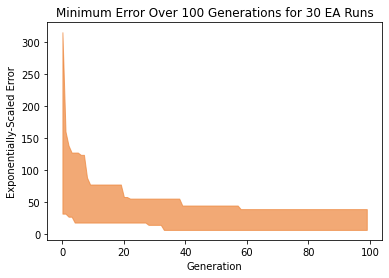

In [21]:
plt.fill_between(range(100),gen_min_errors,gen_max_errors,color="#ED853A",alpha=0.7)
plt.title("Minimum Error Over 100 Generations for 30 EA Runs")
plt.xlabel("Generation")
plt.ylabel("Exponentially-Scaled Error")
plt.savefig('Minimum_Error_Over_100_Generations_for_30_EA_Runs.pdf')  

In [62]:
first_params

["{'exp-expression-const':85,'homotypic-prob':35}",
 "{'exp-expression-const':75,'homotypic-prob':85}",
 "{'exp-expression-const':40,'homotypic-prob':100}",
 "{'exp-expression-const':85,'homotypic-prob':85}",
 "{'exp-expression-const':25,'homotypic-prob':55}",
 "{'exp-expression-const':10,'homotypic-prob':25}",
 "{'exp-expression-const':25,'homotypic-prob':55}",
 "{'exp-expression-const':75,'homotypic-prob':40}",
 "{'exp-expression-const':10,'homotypic-prob':55}",
 "{'exp-expression-const':10,'homotypic-prob':100}",
 "{'exp-expression-const':10,'homotypic-prob':35}",
 "{'exp-expression-const':35,'homotypic-prob':20}",
 "{'exp-expression-const':75,'homotypic-prob':35}",
 "{'exp-expression-const':55,'homotypic-prob':95}",
 "{'exp-expression-const':20,'homotypic-prob':65}",
 "{'exp-expression-const':30,'homotypic-prob':100}",
 "{'exp-expression-const':65,'homotypic-prob':55}",
 "{'exp-expression-const':20,'homotypic-prob':65}",
 "{'exp-expression-const':45,'homotypic-prob':95}",
 "{'exp-e

In [63]:
last_params

["{'exp-expression-const':20,'homotypic-prob':100}",
 "{'exp-expression-const':20,'homotypic-prob':65}",
 "{'exp-expression-const':75,'homotypic-prob':80}",
 "{'exp-expression-const':20,'homotypic-prob':85}",
 "{'exp-expression-const':30,'homotypic-prob':100}",
 "{'exp-expression-const':15,'homotypic-prob':20}",
 "{'exp-expression-const':30,'homotypic-prob':70}",
 "{'exp-expression-const':20,'homotypic-prob':95}",
 "{'exp-expression-const':25,'homotypic-prob':80}",
 "{'exp-expression-const':20,'homotypic-prob':70}",
 "{'exp-expression-const':25,'homotypic-prob':90}",
 "{'exp-expression-const':30,'homotypic-prob':55}",
 "{'exp-expression-const':30,'homotypic-prob':30}",
 "{'exp-expression-const':20,'homotypic-prob':40}",
 "{'exp-expression-const':20,'homotypic-prob':65}",
 "{'exp-expression-const':20,'homotypic-prob':95}",
 "{'exp-expression-const':20,'homotypic-prob':80}",
 "{'exp-expression-const':25,'homotypic-prob':50}",
 "{'exp-expression-const':20,'homotypic-prob':80}",
 "{'exp-ex

In [66]:
min(first_min_errors)

32.17627055829688

In [67]:
max(first_min_errors)

314.7038763982901

In [68]:
min(last_min_errors)

6.864920780836743

In [69]:
max(last_min_errors)

39.25669481751965

In [76]:
upper_thresh = np.quantile(last_min_errors,0.5) + 1.5*(np.quantile(last_min_errors,0.75) - np.quantile(last_min_errors,0.25))
lower_thresh = np.quantile(last_min_errors,0.5) - 1.5*(np.quantile(last_min_errors,0.75) - np.quantile(last_min_errors,0.25))

In [75]:
last_min_errors > upper_thresh

array([False, False,  True, False, False, False, False, False, False,
       False, False,  True, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False])

In [78]:
last_min_errors < lower_thresh

array([False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

In [84]:
first_params = np.array(first_params)
first_params[(lower_thresh < last_min_errors) & (last_min_errors < upper_thresh)]

array(["{'exp-expression-const':85,'homotypic-prob':35}",
       "{'exp-expression-const':75,'homotypic-prob':85}",
       "{'exp-expression-const':85,'homotypic-prob':85}",
       "{'exp-expression-const':25,'homotypic-prob':55}",
       "{'exp-expression-const':10,'homotypic-prob':25}",
       "{'exp-expression-const':25,'homotypic-prob':55}",
       "{'exp-expression-const':10,'homotypic-prob':55}",
       "{'exp-expression-const':10,'homotypic-prob':100}",
       "{'exp-expression-const':10,'homotypic-prob':35}",
       "{'exp-expression-const':75,'homotypic-prob':35}",
       "{'exp-expression-const':55,'homotypic-prob':95}",
       "{'exp-expression-const':20,'homotypic-prob':65}",
       "{'exp-expression-const':65,'homotypic-prob':55}",
       "{'exp-expression-const':20,'homotypic-prob':65}",
       "{'exp-expression-const':45,'homotypic-prob':95}",
       "{'exp-expression-const':15,'homotypic-prob':80}",
       "{'exp-expression-const':40,'homotypic-prob':70}",
       "{'exp

In [87]:
last_params = np.array(last_params)
last_params[(lower_thresh < last_min_errors) & (last_min_errors < upper_thresh)]

array(["{'exp-expression-const':20,'homotypic-prob':100}",
       "{'exp-expression-const':20,'homotypic-prob':65}",
       "{'exp-expression-const':20,'homotypic-prob':85}",
       "{'exp-expression-const':30,'homotypic-prob':100}",
       "{'exp-expression-const':15,'homotypic-prob':20}",
       "{'exp-expression-const':30,'homotypic-prob':70}",
       "{'exp-expression-const':25,'homotypic-prob':80}",
       "{'exp-expression-const':20,'homotypic-prob':70}",
       "{'exp-expression-const':25,'homotypic-prob':90}",
       "{'exp-expression-const':30,'homotypic-prob':30}",
       "{'exp-expression-const':20,'homotypic-prob':40}",
       "{'exp-expression-const':20,'homotypic-prob':65}",
       "{'exp-expression-const':20,'homotypic-prob':80}",
       "{'exp-expression-const':25,'homotypic-prob':50}",
       "{'exp-expression-const':20,'homotypic-prob':80}",
       "{'exp-expression-const':25,'homotypic-prob':65}",
       "{'exp-expression-const':20,'homotypic-prob':50}",
       "{'ex

In [119]:
df = pd.DataFrame(columns=["First_Error","First_Min_Param","Last_Error","Last_Min_Param"])

In [120]:
df["First_Error"] = first_min_errors
df["Last_Error"] = last_min_errors

In [121]:
df["Last_Min_Param"] = last_params

In [122]:
df["First_Min_Param"] = first_params

In [123]:
df["Last_Min_Param"][np.argmin(df["Last_Error"])]

"{'exp-expression-const':20,'homotypic-prob':95}"

In [124]:
df["First_Min_Param"][np.argmax(df["First_Error"])]

"{'exp-expression-const':35,'homotypic-prob':20}"

In [125]:
df

,First_Error,First_Min_Param,Last_Error,Last_Min_Param
0,95.204053,"{'exp-expression-const':85,'homotypic-prob':35}",14.052837,"{'exp-expression-const':20,'homotypic-prob':100}"
1,126.277066,"{'exp-expression-const':75,'homotypic-prob':85}",14.109651,"{'exp-expression-const':20,'homotypic-prob':65}"
2,122.827067,"{'exp-expression-const':40,'homotypic-prob':100}",39.256695,"{'exp-expression-const':75,'homotypic-prob':80}"
3,143.209334,"{'exp-expression-const':85,'homotypic-prob':85}",12.949686,"{'exp-expression-const':20,'homotypic-prob':85}"
4,82.329985,"{'exp-expression-const':25,'homotypic-prob':55}",13.597257,"{'exp-expression-const':30,'homotypic-prob':100}"
5,114.324014,"{'exp-expression-const':10,'homotypic-prob':25}",20.203886,"{'exp-expression-const':15,'homotypic-prob':20}"
6,103.310767,"{'exp-expression-const':25,'homotypic-prob':55}",13.286601,"{'exp-expression-const':30,'homotypic-prob':70}"
7,84.851637,"{'exp-expression-const':75,'homotypic-prob':40}",6.864921,"{'exp-expression-const':20,'homotypic-prob':95}"
8,183.861151,"{'exp-expression-const':10,'homotypic-prob':55}",16.617673,"{'exp-expression-const':25,'homotypic-prob':80}"
9,86.934269,"{'exp-expression-const':10,'homotypic-prob':100}",8.393153,"{'exp-expression-const':20,'homotypic-prob':70}"


# Post-Testing !

In [8]:
nl4py.startServer("/Applications/NetLogo 6.0.4/")

In [10]:
num_cores = 4
model_path = "/Users/niki/Dropbox/Nikita/College/Projects/Lazzara Lab/ABM_Wendell&Lim/Circuit_ABCD_Asymm_01/Callibrate-ABM-HPC/Circuit_ABCD_Asymm_3.1_ParameterTuning.nlogo"
population = 20
generations= 10
reproduction_rate = 0.8
mutation_rate = 0.25
iterations = 10
max_steps = 100

EA = EvolutionaryAlgorithm(num_cores,model_path,population,generations,reproduction_rate,mutation_rate,
                           iterations,max_steps)

{'exp-expression-const': [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'homotypic-prob': [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], 'c-express-delay': [0, 5, 10, 15, 20, 25], 'c-express-thresh': [0, 5, 10, 15, 20], 'd-express-offset': [0, 5, 10, 15, 20, 25]}


In [ ]:
EA_results_exp_error = EA.EA()

---Generation 0---
generation_average: 6653.515485883671
generation_minimum: 54.62876342505083
{'exp-expression-const': 30, 'homotypic-prob': 45, 'c-express-delay': 0, 'c-express-thresh': 0, 'd-express-offset': 5}
20
20
im here
I ran the model.
---Generation 1---
generation_average: 1803.7482335928755
generation_minimum: 54.62876342505083
{'exp-expression-const': 30, 'homotypic-prob': 45, 'c-express-delay': 0, 'c-express-thresh': 0, 'd-express-offset': 5}
20
20
im here
